# Logistic regression for SMS spam classification


Each line of the data file `sms.txt`
contains a label---either "spam" or "ham" (i.e. non-spam)---followed
by a text message. Here are a few examples (line breaks added for readability):

    ham     Ok lar... Joking wif u oni...
    ham     Nah I don't think he goes to usf, he lives around here though
    spam    Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005.
            Text FA to 87121 to receive entry question(std txt rate)
            T&C's apply 08452810075over18's
    spam    WINNER!! As a valued network customer you have been
            selected to receivea £900 prize reward! To claim
            call 09061701461. Claim code KL341. Valid 12 hours only.

To create features suitable for logistic regression, code is provided to do the following (using tools from the ``sklearn.feature_extraction.text``):

* Convert words to lowercase.
* Remove punctuation and special characters (but convert the \$ and
  £ symbols to special tokens and keep them, because these are useful for predicting spam).
* Create a dictionary containing the 3000 words that appeared
  most frequently in the entire set of messages.
* Encode each message as a vector $\mathbf{x}^{(i)} \in
  \mathbb{R}^{3000}$. The entry $x^{(i)}_j$ is equal to the
  number of times the $j$th word in the dictionary appears in that
  message.
* Discard some ham messages to have an
  equal number of spam and ham messages.
* Split data into a training set of 1000 messages and a
  test set of 400 messages.
  
Follow the instructions below to complete the implementation. Your job will be to:

* Learn $\boldsymbol{\theta}$ by gradient descent
* Plot the cost history
* Make predictions and report the accuracy on the test set
* Test out the classifier on a few of your own text messages

# Load and prep data
This cell preps the data. Take a look to see how it works, and then run it.

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np
import re
import matplotlib.pyplot as plt
import codecs

from logistic_regression import logistic, cost_function, gradient_descent
from sklearn.feature_extraction.text import CountVectorizer

# Preprocess the SMS Spam Collection data set
#  
#   https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection
# 
# From Dan Sheldon

numTrain    = 1000
numTest     = 494
numFeatures = 3000

np.random.seed(1)

# Open the file
f = codecs.open('sms.txt', encoding='utf-8')

labels = []    # list of labels for each message
docs   = []    # list of messages

# Go through each line of file and extract the label and the message
for line in f:
    l, d= line.strip().split('\t', 1)
    labels.append(l)
    docs.append(d)

# This function will be called on each message to preprocess it
def preprocess(doc):
    # Replace all currency signs and some url patterns by special
    # tokens. These are useful features.
    doc = re.sub('[£$]', ' __currency__ ', doc)
    doc = re.sub('\://', ' __url__ ', doc)
    doc = doc.lower() # convert to lower
    return doc


# This is the object that does the conversion from text to feature vectors
vectorizer = CountVectorizer(max_features=numFeatures, preprocessor=preprocess)

# Do the conversion ("fit" the transform from text to feature vector. 
#   later we will also "apply" the tranform on test messages)
X = vectorizer.fit_transform(docs)

# Convert labels to numbers: 1 = spam, 0 = ham
y = np.array([l == 'spam' for l in labels]).astype('int')

# The vectorizer returns sparse scipy arrays. Convert this back to a dense 
#   numpy array --- not as efficient but easier to work with
X = X.toarray()
m,n = X.shape

# Add a column of ones
X = np.column_stack([np.ones(m), X])

# 
# Now massage and split into test/train
# 
pos = np.nonzero(y == 1)[0]   # indices of positive training examples
neg = np.nonzero(y == 0)[0]   # indices of negative training examples

npos = len(pos)

# Create a subset that has the same number of positive and negative examples
subset = np.concatenate([pos, neg[0:len(pos)] ])

# Randomly shuffle order of examples
np.random.shuffle(subset)
      
X = X[subset,:]
y = y[subset]

# Split into test and train
train = np.arange(numTrain)
test  = numTrain + np.arange(numTest)

X_train = X[train,:]
y_train = y[train]

X_test  = X[test,:]
y_test  = y[test]

# Extract the list of test documents
test_docs = [docs[i] for i in subset[test]]

# Extract the list of tokens (words) in the dictionary
tokens = vectorizer.get_feature_names()

# Train logistic regresion model
Now train the logistic regression model. The comments summarize the relevant variables created by the preprocessing.

In [3]:
# X_train     contains information about the words within the training
#             messages. the ith row represents the ith training message. 
#             for a particular text, the entry in the jth column tells
#             you how many times the jth dictionary word appears in 
#             that message
#
# X_test      similar but for test set
#
# y_train     ith entry indicates whether message i is spam
#
# y_test      similar
#

m, n = X_train.shape

theta = np.zeros(n)

alpha = 0.01
iters = 1500
theta, J_history = gradient_descent(X_train, y_train, theta, alpha, iters)

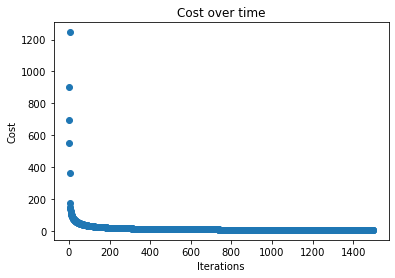

In [4]:
plt.scatter(range(iters), J_history)
plt.title('Cost over time')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

# Make predictions on test set
Use the model fit in the previous cell to make predictions on the test set and compute the accuracy (percentage of messages in the test set that are classified correctly). You should be able to get accuracy above 95%.


In [5]:
m_test, n_test = X_test.shape

h_theta = lambda X_i: logistic(np.dot(theta.T, X_i))
predictions = np.round(np.apply_along_axis(h_theta, 1, X_test))
correct_classifications = predictions[predictions == y_test]

print("Accuracy: %.2f" % ((correct_classifications.shape[0] / predictions.shape[0]) * 100) + "%")

Accuracy: 96.56%


# Inspect model parameters
Run this code to examine the model parameters you just learned. These parameters assign a postive or negative value to each word --- where positive values are words that tend to be spam and negative values are words that tend to be ham. Do they make sense?

In [6]:
token_weights = theta[1:]

def reverse(a):
    return a[::-1]

most_negative = np.argsort(token_weights)
most_positive = reverse(most_negative)

k = 10

print('Top %d spam words' % k)
for i in most_positive[0:k]:
    print('  %+.4f  %s' % (token_weights[i], tokens[i]))

print('\nTop %d ham words' % k)
for i in most_negative[0:k]:
    print('  %+.4f  %s' % (token_weights[i], tokens[i]))


Top 10 spam words
  +5.8450  ringtoneking
  +4.8168  __currency__
  +4.2248  text
  +3.2305  txt
  +3.0174  ringtone
  +2.9719  service
  +2.8033  message
  +2.7762  150p
  +2.6823  mobile
  +2.6582  call

Top 10 ham words
  -3.4839  waiting
  -2.5135  ok
  -2.2588  later
  -2.2045  so
  -2.2045  what
  -2.1207  ll
  -1.9858  my
  -1.9303  me
  -1.7962  he
  -1.7923  come


## Make a prediction on new messages
Type a few of your own messages in below and make predictions. Are they ham or spam? Do the predictions make sense?

In [7]:
def extract_features(msg):
    x = vectorizer.transform([msg]).toarray()
    x = np.insert(x, 0, 1)
    return x

msg = u'Write your own text here...'
x = extract_features(msg)  # this is the feature vector

msgs = [
    u'hey jennifer how was your weekend?', 
    u'REPLY: text 15003 to this number for free iPhone', 
    u'CONGRATS you won a raffle for Amazon $50 gift card!!', 
    u'can u pick up sum eggs from store after work',
    u'dude i cant call u rn bc i got rly bad service',
    u'text me later when ur free, i got a surprise for u',
    u'can u text me when u get home'
]
for msg in msgs:
    x = extract_features(msg)
    print("msg: ", msg)
    print("prediction: ", end="")
    print("ham" if np.sum(np.dot(theta.T, x)) < 0 else "spam")
    print()

msg:  hey jennifer how was your weekend?
prediction: ham

msg:  REPLY: text 15003 to this number for free iPhone
prediction: spam

msg:  CONGRATS you won a raffle for Amazon $50 gift card!!
prediction: spam

msg:  can u pick up sum eggs from store after work
prediction: ham

msg:  dude i cant call u rn bc i got rly bad service
prediction: ham

msg:  text me later when ur free, i got a surprise for u
prediction: ham

msg:  can u text me when u get home
prediction: ham

